In [2]:
import sys
import socket

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    sys.path.extend(['/home/jorg/repository/seg_eval_pipeline'])
else:
    sys.path.extend(['/home/jorg/repo/seg_eval_pipeline'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

import numpy as np
import torch
from collections import OrderedDict

from io_tools.acdc.data_handler_phase import ACDCDataHandlerPhase
from io_tools.acdc.detector_dataset import RegionDetectorDataSet
from io_tools.acdc.create_detector_dataset import create_dataset
from config.dcnn.general_setup import base_config as dcnn_config
from config.region_detector.general_setup import config_detector

from utils.region_detector.batch_handler import BatchHandler
from models.model_handler import ModelHandler

from plotting.color_maps import transparent_cmap


mycmap = transparent_cmap(plt.get_cmap('jet'))
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Ready")

Ready


# Generate distance transform maps and target detection labels

1. **first**, generate dt-maps and targets with mc_dropout equal to **False** and use_existing_dt_maps to **False**
2. **second**, re-run for the same fold with mc_dropout equal to **True** and use_existing_dt_maps to **True** so you generate mc low-quality seg-errors without re-generating the dt maps
3. **IMPORTANT**: You can't specify fold_id if you are running for specific patient ids (list of strings)
4. **IMPORTANT**: parameter error_margins needs to be a tuple where (1) outside tissue structure tolerance margin and (2) inside. Also **note** that these should be only specified if you want to use a fixed margin

In [33]:

fold_id = 0
mc_dropout = True
use_existing_dt_maps = True if mc_dropout else False
patient_ids = None # ["patient001"]  # must be a list of patient ids (strings)
error_margins = tuple((4.2, 2.8))
use_fixed_margin = True

# IMPORTANT MC_DROPOUT?
# REMEMBER: if you already generated DT maps, you don't need to do that again for generating t_roi_maps!

data_handler = ACDCDataHandlerPhase(dcnn_config, "brier")
data_handler.detection_generator(fold_id=fold_id, patient_ids=patient_ids, do_save_nifti=False, 
                                 mc_dropout=mc_dropout, adjust_to_roi=False, 
                                 error_margins=error_margins, use_fixed_margin=use_fixed_margin,
                                 use_existing_dt_maps=use_existing_dt_maps)
print("INFO - Ready")

WARNING - using fixed margins outside: 4.200 inside: 2.800
WARNING - using /home/jorg/data/ACDC/brier/dt_maps/fixed_42_28 as output dir for dt-maps!
INFO - Ready


## Compute statistics for tolerance scenario

In [3]:
fold_id = 0

dt_config_id = "fixed_42_28"

data_handler = ACDCDataHandlerPhase(dcnn_config, "brier")
data_handler.get_acdc_images_labels(fold_id=fold_id, load_images=False, load_ref_labels=False)
data_handler.set_dt_config_id(dt_config_id)

Loading test dataset:   4%|▍         | 1/25 [00:00<00:07,  3.40it/s]/home/jorg/anaconda2/envs/pyt_1_0_0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Using SeparatePhaseVolume: 100%|██████████| 25/25 [00:00<00:00, 81284.96it/s]


In [4]:
perc_es, perc_ed, seg_perc_es, seg_perc_ed = [], [], [], []
seg_perc_a_b_es, seg_perc_a_b_ed = [], []

for patient_id, phase_ids in data_handler.phase_trans_dict.items():
    for phase_id in phase_ids.values():
        
        target_labels = data_handler.get_detector_target_labels(patient_id, phase_id, mc_dropout=False)
        apex = data_handler.apex_base_slice[patient_id][phase_id]['A'].astype(np.bool)
        base = data_handler.apex_base_slice[patient_id][phase_id]['B'].astype(np.bool)
        seg_errors = data_handler.get_pred_labels_errors(patient_id, phase_id, mc_dropout=False)
        seg_errors = np.any(seg_errors, axis=0)
        # NOTE seg_errors [x, y, z]
        seg_errors_a_b = np.count_nonzero(seg_errors[...,apex]) + np.count_nonzero(seg_errors[...,base])
        total_target_errors = np.any(target_labels, axis=0)
        target_labels = np.any(target_labels, axis=(0, 1, 2))
        perc = np.count_nonzero(target_labels)/target_labels.shape[0]
        perc_error = np.count_nonzero(total_target_errors)/np.count_nonzero(seg_errors)
        perc_error_a_b =  seg_errors_a_b/np.count_nonzero(seg_errors)
        
        if perc == 0:
            print("Hey {} {}".format(patient_id, phase_id))
        if phase_id == 1:
            perc_ed.append(perc)
            seg_perc_ed.append(perc_error)
            seg_perc_a_b_ed.append(perc_error_a_b)
        else:
            seg_perc_a_b_es.append(perc_error_a_b)
            perc_es.append(perc)
            seg_perc_es.append(perc_error)
print("ED perc slices with errors {:.2f}".format(np.mean(np.array(perc_ed))))
print("ES perc slices with errors {:.2f}".format(np.mean(np.array(perc_es))))
print("ED perc low-quality errors {:.2f}".format(np.mean(np.array(seg_perc_ed))))
print("ES perc low-quality errors {:.2f}".format(np.mean(np.array(seg_perc_es))))
print("ED perc Apex/Base {:.5f}".format(np.mean(np.array(seg_perc_a_b_ed))))
print("ES perc Apex/Base {:.5f}".format(np.mean(np.array(seg_perc_a_b_es))))

ED perc slices with errors 0.41
ES perc slices with errors 0.75
ED perc low-quality errors 0.19
ES perc low-quality errors 0.47
ED perc Apex/Base 0.24479
ES perc Apex/Base 0.28351


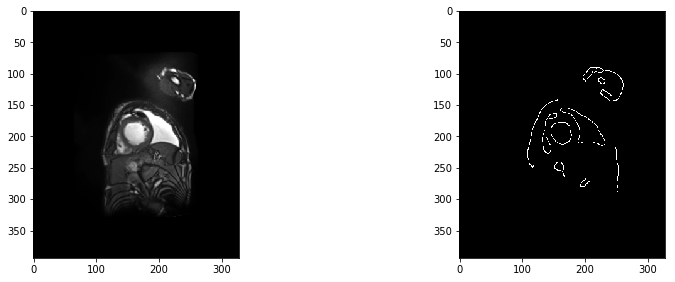

In [22]:
from skimage import feature

image_ed = data_handler.get_image(patient_id="patient016", frame_id=1)
image_slice = image_ed[..., 7]

edges1 = feature.canny(image_slice, sigma=3.5)

plt.rcParams['figure.figsize']=[14, 10]
plt.subplot(221)
plt.imshow(image_slice, cmap=cm.gray)
plt.subplot(222)
plt.imshow(edges1, cmap=cm.gray)
plt.show()

In [ ]:
# outside 5.6mm inside 4.2mm
ED perc slices with errors 0.34
ES perc slices with errors 0.64
ED perc low-quality errors 0.17
ES perc low-quality errors 0.41
ED perc Apex/Base 0.24479
ES perc Apex/Base 0.28351

# outside 4.2mm inside 2.8mm
ED perc slices with errors 0.41
ES perc slices with errors 0.75
ED perc low-quality errors 0.19
ES perc low-quality errors 0.47
ED perc Apex/Base 0.24479
ES perc Apex/Base 0.28351

# outside 5.6mm inside 2.8mm
ED perc slices with errors 0.38
ES perc slices with errors 0.68
ED perc low-quality errors 0.18
ES perc low-quality errors 0.44
ED perc Apex/Base 0.24479
ES perc Apex/Base 0.28351

In [7]:
from utils.region_detector.generate_dt_maps import FilterSegErrors

patient_id = "patient039"
frame_id = 10

data_handler = ACDCDataHandlerPhase(dcnn_config, "brier")
data_handler.set_dt_config_id(dt_config_id)
pred_labels = data_handler.get_pred_labels(patient_id, frame_id)
seg_errors = data_handler.get_pred_labels_errors(patient_id, frame_id)
dt_maps = data_handler.get_dt_maps(patient_id, frame_id)
filtered_seg_errors = data_handler.get_detector_target_labels(patient_id, frame_id)
apex_base_indicators = data_handler.apex_base_slice[patient_id][frame_id]

In [8]:
# filter_errors = FilterSegErrors(pred_labels, seg_errors, dt_maps, apex_base_indicators
#                                ['A'], apex_base_indicators['B'])
# or from file
filter_errors = data_handler.get_detector_target_labels(patient_id, frame_id, mc_dropout=False, force_reload=True)

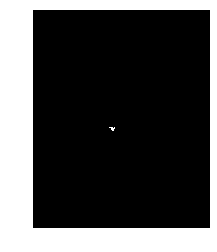

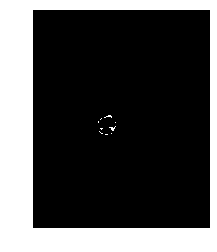

In [28]:
cls_idx = 3
slice_idx = 0
plt.imshow(filtered_seg_errors[cls_idx, :, :, slice_idx], cmap=cm.gray)
plt.axis("off")
plt.show()
plt.imshow(seg_errors[cls_idx, :, :, slice_idx], cmap=cm.gray)
plt.axis("off")
plt.show()


In [3]:
data_handler = ACDCDataHandlerPhase(dcnn_config, "brier")
output_dir = "/home/jorg/data/ACDC/seg_errors/"
patient_ids = None
data_handler.save_seg_errors(fold_id=0, patient_ids=patient_ids, output_dir=output_dir)

100%|██████████| 25/25 [00:01<00:00, 13.86it/s]


506.0 5320.0
12 7695 2709.0 2800.490566037736


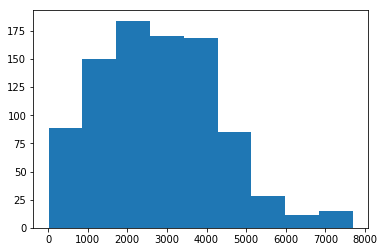

In [6]:
from common.detector.box_utils import BoundingBox

areas_es, areas_ed = [], []
fold_ids = [0, 1, 2, 3]

for fold_id in fold_ids:
    exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]
    exper_handler.get_test_set()
    exper_handler.test_set.generate_bbox_target_roi()
    target_roi_slices = exper_handler.test_set.labels_target_roi
    for patient_id, pat_slice_rois in target_roi_slices.iteritems():
        # print(patient_id, pat_slice_rois.keys()) 
        for slice_id, slice_rois in pat_slice_rois.iteritems():
            # first index ES/ED, second index slice_x, slice_y
            roi_box_es = BoundingBox(slice_rois[0][0], slice_rois[0][1])
            roi_box_ed = BoundingBox(slice_rois[1][0], slice_rois[1][1])
            area = roi_box_es.width * roi_box_es.height
            if area != 0:
                # if area < 567 or area > 5698:
                    # print(patient_id, area, slice_id)
                areas_es.append(area)
            area = roi_box_ed.width * roi_box_ed.height
            if area != 0:
                areas_ed.append(area)
    
    exper_handler.test_set = None
    
areas_es = np.array(areas_es)
lower, upper = np.percentile(areas_es, [5, 95], axis=0)
print(lower, upper)
print(np.min(areas_es), np.max(areas_es), np.median(areas_es), np.mean(areas_es))
_ = plt.hist(areas_es, bins=9)            
plt.show()